In [1]:
import pandas as pd # to import csv and for data manipulation
import matplotlib.pyplot as plt # to plot graph
import seaborn as sns # for intractve graphs
import numpy as np # for linear algebra
import datetime # to dela with date and time
%matplotlib inline
from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split # to split the data
from sklearn.cross_validation import KFold # For cross vbalidation
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
warnings.filterwarnings('ignore')

C:\Users\Ankit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv("input/creditcard.csv",header = 0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

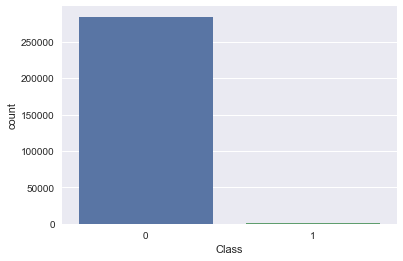

In [4]:
# Now lets check the class distributions
sns.countplot("Class",data=data)

In [5]:
# now let us check in the number of Percentage
Count_Normal_transacation = len(data[data["Class"]==0]) # normal transaction are repersented by 0
Count_Fraud_transacation = len(data[data["Class"]==1]) # fraud by 1
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("percentage of normal transacation is",Percentage_of_Normal_transacation*100)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("percentage of fraud transacation",Percentage_of_Fraud_transacation*100)

percentage of normal transacation is 99.82725143693798
percentage of fraud transacation 0.1727485630620034


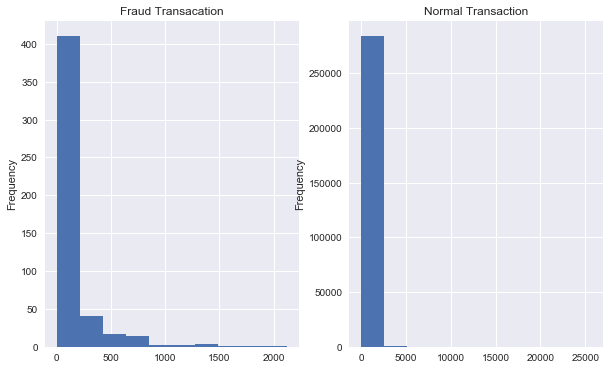

In [6]:
Fraud_transacation = data[data["Class"]==1]
Normal_transacation= data[data["Class"]==0]
plt.figure(figsize=(10,6))
plt.subplot(121)
Fraud_transacation.Amount.plot.hist(title="Fraud Transacation")
plt.subplot(122)
Normal_transacation.Amount.plot.hist(title="Normal Transaction")

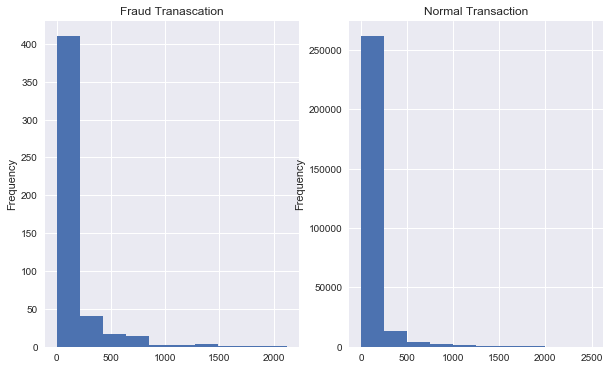

In [7]:
# the distribution for Normal transction is not clear and it seams that all transaction are less than 2.5 K
# So plot graph for same 
Fraud_transacation = data[data["Class"]==1]
Normal_transacation= data[data["Class"]==0]
plt.figure(figsize=(10,6))
plt.subplot(121)
Fraud_transacation[Fraud_transacation["Amount"]<= 2500].Amount.plot.hist(title="Fraud Tranascation")
plt.subplot(122)
Normal_transacation[Normal_transacation["Amount"]<=2500].Amount.plot.hist(title="Normal Transaction")

In [8]:
# for undersampling we need a portion of majority class and will take whole data of minority class
# count fraud transaction is the total number of fraud transaction
# now lets us see the index of fraud cases
fraud_indices= np.array(data[data.Class==1].index)
normal_indices = np.array(data[data.Class==0].index)
#now let us a define a function for make undersample data with different proportion
#different proportion means with different proportion of normal classes of data
def undersample(normal_indices,fraud_indices,times):#times denote the normal data = times*fraud data
    Normal_indices_undersample = np.array(np.random.choice(normal_indices,(times*Count_Fraud_transacation),replace=False))
    undersample_data= np.concatenate([fraud_indices,Normal_indices_undersample])
    undersample_data = data.iloc[undersample_data,:]
    
    print("the normal transacation proportion is :",len(undersample_data[undersample_data.Class==0])/len(undersample_data[undersample_data.Class]))
    print("the fraud transacation proportion is :",len(undersample_data[undersample_data.Class==1])/len(undersample_data[undersample_data.Class]))
    print("total number of record in resampled data is:",len(undersample_data[undersample_data.Class]))
    return(undersample_data)

In [9]:
## first make a model function for modeling with confusion matrix
def model(model,features_train,features_test,labels_train,labels_test):
    clf= model
    clf.fit(features_train,labels_train.values.ravel())
    pred=clf.predict(features_test)
    cnf_matrix=confusion_matrix(labels_test,pred)
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))

In [21]:
def data_prepration(x): # preparing data for training and testing as we are going to use different data 
    #again and again so make a function
    x_features= x.ix[:,x.columns != "Class"]
    x_labels=x.ix[:,x.columns=="Class"]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    return(x_features_train,x_features_test,x_labels_train,x_labels_test)

In [22]:
# before starting we should standridze our ampount column
data["Normalized Amount"] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data.drop(["Time","Amount"],axis=1,inplace=True)
data.head()

KeyError: 'Amount'

the undersample data for 1 proportion

the normal transacation proportion is : 0.5
the fraud transacation proportion is : 0.5
total number of record in resampled data is: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296

the recall for this model is : 0.913907284768
TP 138
TN 140
FP 5
FN 13


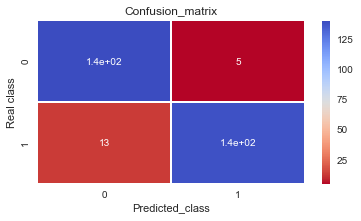


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       145
          1       0.97      0.91      0.94       151

avg / total       0.94      0.94      0.94       296

________________________________________________________________________________________________________
the undersample data for 2 proportion

the normal transacation proportion is : 0.6666666666666666
the fraud transacation proportion is : 0.3333333333333333
total number of record in resampled data is: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443

the recall for this model is : 0.911764705882
TP 124
TN 301
FP 6
FN 12


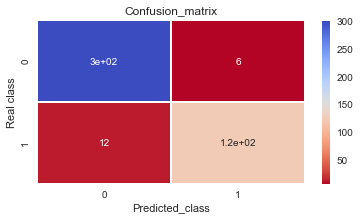


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       307
          1       0.95      0.91      0.93       136

avg / total       0.96      0.96      0.96       443

________________________________________________________________________________________________________
the undersample data for 3 proportion

the normal transacation proportion is : 0.75
the fraud transacation proportion is : 0.25
total number of record in resampled data is: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591

the recall for this model is : 0.891304347826
TP 123
TN 448
FP 5
FN 15


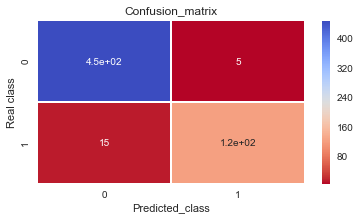


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       453
          1       0.96      0.89      0.92       138

avg / total       0.97      0.97      0.97       591

________________________________________________________________________________________________________


In [23]:
# Now make undersample data with differnt portion
# here i will take normal trasaction in  0..5 %, 0.66% and 0.75 % proportion of total data now do this for 
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    print()
    clf=LogisticRegression()
    model(clf,undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test)
    print("________________________________________________________________________________________________________")
    
# here 1st proportion conatain 50% normal transaction
#Proportion 2nd contains 66% noraml transaction
#proportion 3rd contains 75 % normal transaction

the undersample data for 1 proportion

the normal transacation proportion is : 0.5
the fraud transacation proportion is : 0.5
total number of record in resampled data is: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296
length of training data
199364
length of test data
85443

the recall for this model is : 0.913669064748
TP 127
TN 82939
FP 2365
FN 12


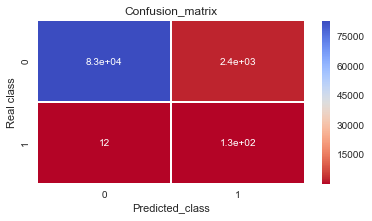


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     85304
          1       0.05      0.91      0.10       139

avg / total       1.00      0.97      0.98     85443

_________________________________________________________________________________________
the undersample data for 2 proportion

the normal transacation proportion is : 0.6666666666666666
the fraud transacation proportion is : 0.3333333333333333
total number of record in resampled data is: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443
length of training data
199364
length of test data
85443

the recall for this model is : 0.924137931034
TP 134
TN 83319
FP 1979
FN 11


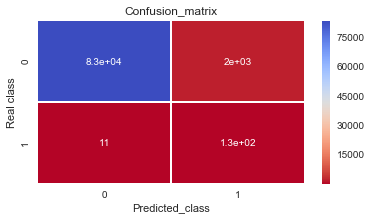


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85298
          1       0.06      0.92      0.12       145

avg / total       1.00      0.98      0.99     85443

_________________________________________________________________________________________
the undersample data for 3 proportion

the normal transacation proportion is : 0.75
the fraud transacation proportion is : 0.25
total number of record in resampled data is: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591
length of training data
199364
length of test data
85443

the recall for this model is : 0.884892086331
TP 123
TN 84378
FP 926
FN 16


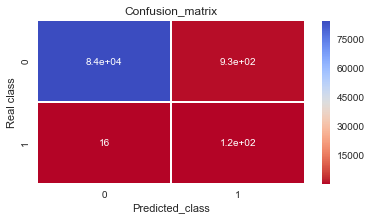


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     85304
          1       0.12      0.88      0.21       139

avg / total       1.00      0.99      0.99     85443

_________________________________________________________________________________________


In [24]:
#let us train this model using undersample data and test for the whole data test set 
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    data_features_train,data_features_test,data_labels_train,data_labels_test=data_prepration(data) 
    #the partion for whole data
    print()
    clf=LogisticRegression()
    model(clf,undersample_features_train,data_features_test,undersample_labels_train,data_labels_test)
    # here training for the undersample data but tatsing for whole data
    print("_________________________________________________________________________________________")

the undersample data for 1 proportion

the normal transacation proportion is : 0.5
the fraud transacation proportion is : 0.5
total number of record in resampled data is: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296

the recall for this model is : 0.912751677852
TP 136
TN 138
FP 9
FN 13


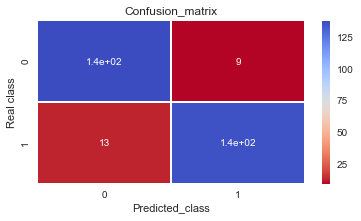


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       147
          1       0.94      0.91      0.93       149

avg / total       0.93      0.93      0.93       296

________________________________________________________________________________________________________
the undersample data for 2 proportion

the normal transacation proportion is : 0.6666666666666666
the fraud transacation proportion is : 0.3333333333333333
total number of record in resampled data is: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443

the recall for this model is : 0.866197183099
TP 123
TN 293
FP 8
FN 19


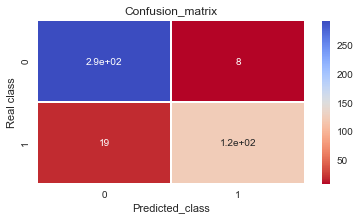


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.94      0.97      0.96       301
          1       0.94      0.87      0.90       142

avg / total       0.94      0.94      0.94       443

________________________________________________________________________________________________________
the undersample data for 3 proportion

the normal transacation proportion is : 0.75
the fraud transacation proportion is : 0.25
total number of record in resampled data is: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591

the recall for this model is : 0.849673202614
TP 130
TN 429
FP 9
FN 23


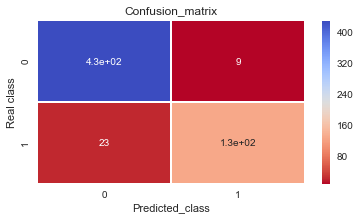


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       438
          1       0.94      0.85      0.89       153

avg / total       0.95      0.95      0.94       591

________________________________________________________________________________________________________


In [27]:
#SVM with Undersample data
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    print()
    clf= SVC()# here we are just changing classifier
    model(clf,undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test)
    print("________________________________________________________________________________________________________")
    

the undersample data for 1 proportion

the normal transacation proportion is : 0.5
the fraud transacation proportion is : 0.5
total number of record in resampled data is: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296
length of training data
199364
length of test data
85443

the recall for this model is : 0.906040268456
TP 135
TN 81071
FP 4223
FN 14


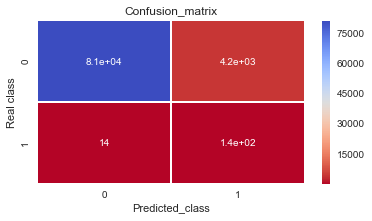


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     85294
          1       0.03      0.91      0.06       149

avg / total       1.00      0.95      0.97     85443

_________________________________________________________________________________________
the undersample data for 2 proportion

the normal transacation proportion is : 0.6666666666666666
the fraud transacation proportion is : 0.3333333333333333
total number of record in resampled data is: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443
length of training data
199364
length of test data
85443

the recall for this model is : 0.93125
TP 149
TN 82275
FP 3008
FN 11


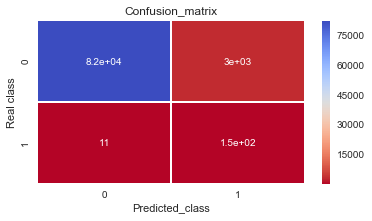


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     85283
          1       0.05      0.93      0.09       160

avg / total       1.00      0.96      0.98     85443

_________________________________________________________________________________________
the undersample data for 3 proportion

the normal transacation proportion is : 0.75
the fraud transacation proportion is : 0.25
total number of record in resampled data is: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591
length of training data
199364
length of test data
85443

the recall for this model is : 0.921428571429
TP 129
TN 83370
FP 1933
FN 11


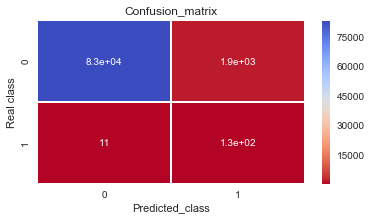


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85303
          1       0.06      0.92      0.12       140

avg / total       1.00      0.98      0.99     85443

_________________________________________________________________________________________


In [28]:
#let us train this model using undersample data and test for the whole data test set 
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    data_features_train,data_features_test,data_labels_train,data_labels_test=data_prepration(data) 
    #the partion for whole data
    print()
    clf=SVC()
    model(clf,undersample_features_train,data_features_test,undersample_labels_train,data_labels_test)
    # here training for the undersample data but tatsing for whole data
    print("_________________________________________________________________________________________")


the undersample data for 1 proportion

the normal transacation proportion is : 0.5
the fraud transacation proportion is : 0.5
total number of record in resampled data is: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296

the recall for this model is : 0.875816993464
TP 134
TN 141
FP 2
FN 19


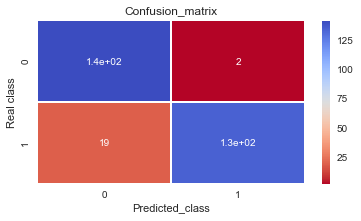


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.88      0.99      0.93       143
          1       0.99      0.88      0.93       153

avg / total       0.94      0.93      0.93       296

________________________________________________________________________________________________________
the undersample data for 2 proportion

the normal transacation proportion is : 0.6666666666666666
the fraud transacation proportion is : 0.3333333333333333
total number of record in resampled data is: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443

the recall for this model is : 0.891304347826
TP 123
TN 303
FP 2
FN 15


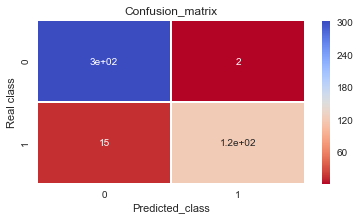


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.95      0.99      0.97       305
          1       0.98      0.89      0.94       138

avg / total       0.96      0.96      0.96       443

________________________________________________________________________________________________________
the undersample data for 3 proportion

the normal transacation proportion is : 0.75
the fraud transacation proportion is : 0.25
total number of record in resampled data is: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591

the recall for this model is : 0.908536585366
TP 149
TN 425
FP 2
FN 15


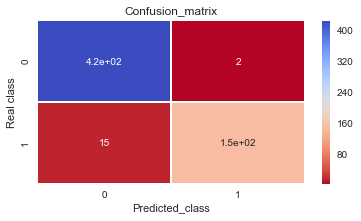


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       427
          1       0.99      0.91      0.95       164

avg / total       0.97      0.97      0.97       591

________________________________________________________________________________________________________


In [29]:
# Random Forest Classifier with undersample data only
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    print()
    clf= RandomForestClassifier(n_estimators=100)# here we are just changing classifier
    model(clf,undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test)
    print("________________________________________________________________________________________________________")


the undersample data for 1 proportion

the normal transacation proportion is : 0.5
the fraud transacation proportion is : 0.5
total number of record in resampled data is: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296
length of training data
199364
length of test data
85443

the recall for this model is : 0.975308641975
TP 158
TN 83271
FP 2010
FN 4


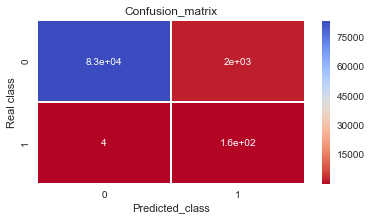


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85281
          1       0.07      0.98      0.14       162

avg / total       1.00      0.98      0.99     85443

_________________________________________________________________________________________
the undersample data for 2 proportion

the normal transacation proportion is : 0.6666666666666666
the fraud transacation proportion is : 0.3333333333333333
total number of record in resampled data is: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443
length of training data
199364
length of test data
85443

the recall for this model is : 0.957446808511
TP 135
TN 84014
FP 1288
FN 6


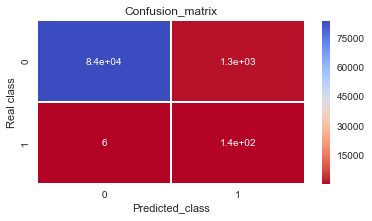


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85302
          1       0.09      0.96      0.17       141

avg / total       1.00      0.98      0.99     85443

_________________________________________________________________________________________
the undersample data for 3 proportion

the normal transacation proportion is : 0.75
the fraud transacation proportion is : 0.25
total number of record in resampled data is: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591
length of training data
199364
length of test data
85443

the recall for this model is : 0.972413793103
TP 141
TN 84862
FP 436
FN 4


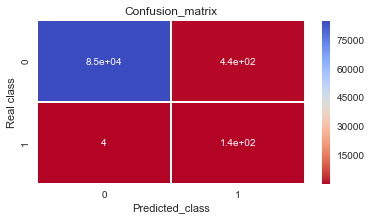


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85298
          1       0.24      0.97      0.39       145

avg / total       1.00      0.99      1.00     85443

_________________________________________________________________________________________


In [30]:
#let us train this model using undersample data and test for the whole data test set 
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    data_features_train,data_features_test,data_labels_train,data_labels_test=data_prepration(data) 
    #the partion for whole data
    print()
    clf=RandomForestClassifier(n_estimators=100)
    model(clf,undersample_features_train,data_features_test,undersample_labels_train,data_labels_test)
    # here training for the undersample data but tatsing for whole data
    print("_________________________________________________________________________________________")


In [31]:
featimp = pd.Series(clf.feature_importances_,index=data_features_train.columns).sort_values(ascending=False)
print(featimp) # this is the property of Random Forest classifier that it provide us the importance 
# of the features use

V14                  0.165853
V10                  0.157881
V11                  0.102465
V17                  0.101434
V12                  0.091492
V3                   0.060737
V4                   0.045943
V16                  0.043207
V2                   0.027424
V7                   0.026461
V18                  0.021042
V9                   0.017635
V27                  0.013134
V6                   0.011928
V19                  0.010242
Normalized Amount    0.010143
V20                  0.009931
V8                   0.009055
V23                  0.008422
V15                  0.007666
V21                  0.007583
V26                  0.007569
V13                  0.007003
V28                  0.006245
V24                  0.006226
V1                   0.006080
V22                  0.006042
V25                  0.005721
V5                   0.005436
dtype: float64


In [33]:
# make a new data with only class and V14
data1=data[["V14","V10","V12","V17","V4","Class"]]
data1.head()

,V14,V10,V12,V17,V4,Class
0,-0.311169,0.090794,-0.617801,0.207971,1.378155,0
1,-0.143772,-0.166974,1.065235,-0.114805,0.448154,0
2,-0.165946,0.207643,0.066084,1.109969,0.379780,0
3,-0.287924,-0.054952,0.178228,-0.684093,-0.863291,0
4,-1.119670,0.753074,0.538196,-0.237033,0.403034,0


In [34]:
Undersample_data1 = undersample(normal_indices,fraud_indices,1)
#only for 50 % proportion it means normal transaction and fraud transaction are equal so passing 
Undersample_data1_features_train,Undersample_data1_features_test,Undersample_data1_labels_train,Undersample_data1_labels_test = data_prepration(Undersample_data1)

the normal transacation proportion is : 0.5
the fraud transacation proportion is : 0.5
total number of record in resampled data is: 984
length of training data
688
length of test data
296


the recall for this model is : 0.89932885906
TP 134
TN 143
FP 4
FN 15


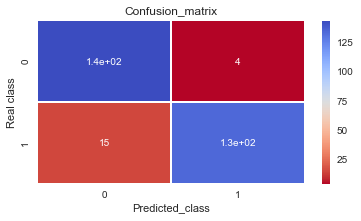


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.97      0.94       147
          1       0.97      0.90      0.93       149

avg / total       0.94      0.94      0.94       296



In [35]:
clf= RandomForestClassifier(n_estimators=100)
model(clf,Undersample_data1_features_train,Undersample_data1_features_test,Undersample_data1_labels_train,Undersample_data1_labels_test)

In [37]:
# now we will divied our data sets into two part and we will train and test and will oversample the train data and predict for test data
# lets import data again
data = pd.read_csv("input/creditcard.csv",header = 0)
print("length of training data",len(data))
print("length of normal data",len(data[data["Class"]==0]))
print("length of fraud  data",len(data[data["Class"]==1]))

length of training data 284807
length of normal data 284315
length of fraud  data 492


In [38]:
data_train_X,data_test_X,data_train_y,data_test_y=data_prepration(data)
data_train_X.columns
data_train_y.columns

length of training data
199364
length of test data
85443


Index(['Class'], dtype='object')